In [1]:
# Utilities
import pandas as pd # read csv
import numpy as np # linear algebra
import random

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Model training and validation
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import precision_score, classification_report, recall_score,\
                            confusion_matrix, accuracy_score, f1_score, \
                            average_precision_score, make_scorer

# Model selection
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Validation models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Visualization tools
from graphviz import Digraph
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameter tuning utilities
from sklearn.model_selection import GridSearchCV
from time import time
from datetime import timedelta

# Console settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(0)
sc_X = StandardScaler()

In [3]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    pred = pd.Series(pred)
    true = pd.Series(true)
    
    cm = pd.DataFrame(confusion_matrix(true, pred))
    cm.index.name = 'target'
    cm.columns.name = 'predicted'
    return cm


def graphMLP(vars,layers,intercepts):
    """
    Function for plotting the weights of a mlp
    """
    f = Digraph('')
    f.attr(rankdir='LR')
    for i,l in enumerate(layers):
        if i==0:
            for j in range(l.shape[1]):
                for k, v in enumerate(vars):
                    f.edge(v, 'L%dN%d'%(i,j), label=str(l[k,j]))
            f.node('ILI', shape='doublecircle')                    
            for k in range(intercepts[i].shape[0]): 
                f.edge('ILI', 
                       'L%dN%d'%(i,k), 
                       label=str(intercepts[i][k]))
        else:
            for j in range(l.shape[1]):
                for k in range(layers[i-1].shape[1]):
                    f.edge('L%dN%d'%(i-1,k), 
                           'L%dN%d'%(i,j), 
                           label=str(l[k,j]))
            f.node('L%dI'%(i-1), shape='doublecircle')                  
            for k in range(intercepts[i].shape[0]):
                f.edge('L%dI'%(i-1), 
                       'L%dN%d'%(i,k), 
                       label=str(intercepts[i][k]))        
    return f

def compute_metrics(y_real,y_pred):
    # By default it will compute the binary recall of class 1, we can specify which class do we want by using this parameter 
    f1_score_pass = f1_score(y_real, y_pred,average='binary', pos_label=1)
    f1_score_fail = f1_score(y_real, y_pred,average='binary', pos_label=0)
    f1_macro = f1_score(y_real,y_pred, average='macro')
    accuracy = accuracy_score(y_real, y_pred)
    return [f1_score_pass, f1_score_fail, f1_macro, accuracy ]

results_port = pd.DataFrame(index=[], columns= ['**F1-score (class pass)**', '**F1-score (class fail)**','F1-score (macro avg)', 'Accuracy'])

In [4]:
mathdata = pd.read_csv('student/student-mat.csv', sep=";")
portdata = pd.read_csv('student/student-por.csv', sep=";")

# Exploratory Data Analysis

In [5]:
nRow, nCol = mathdata.shape
print(f'There are {nRow} rows and {nCol} columns')

nRow, nCol = portdata.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 395 rows and 33 columns
There are 649 rows and 33 columns


In [6]:
print(mathdata.info())
print(portdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

There are no nulls.

In [7]:
pd.options.display.max_columns = None
mathdata.head(5)
portdata.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [8]:
mathdata.describe()
portdata.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [9]:
mathdata.columns
portdata.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

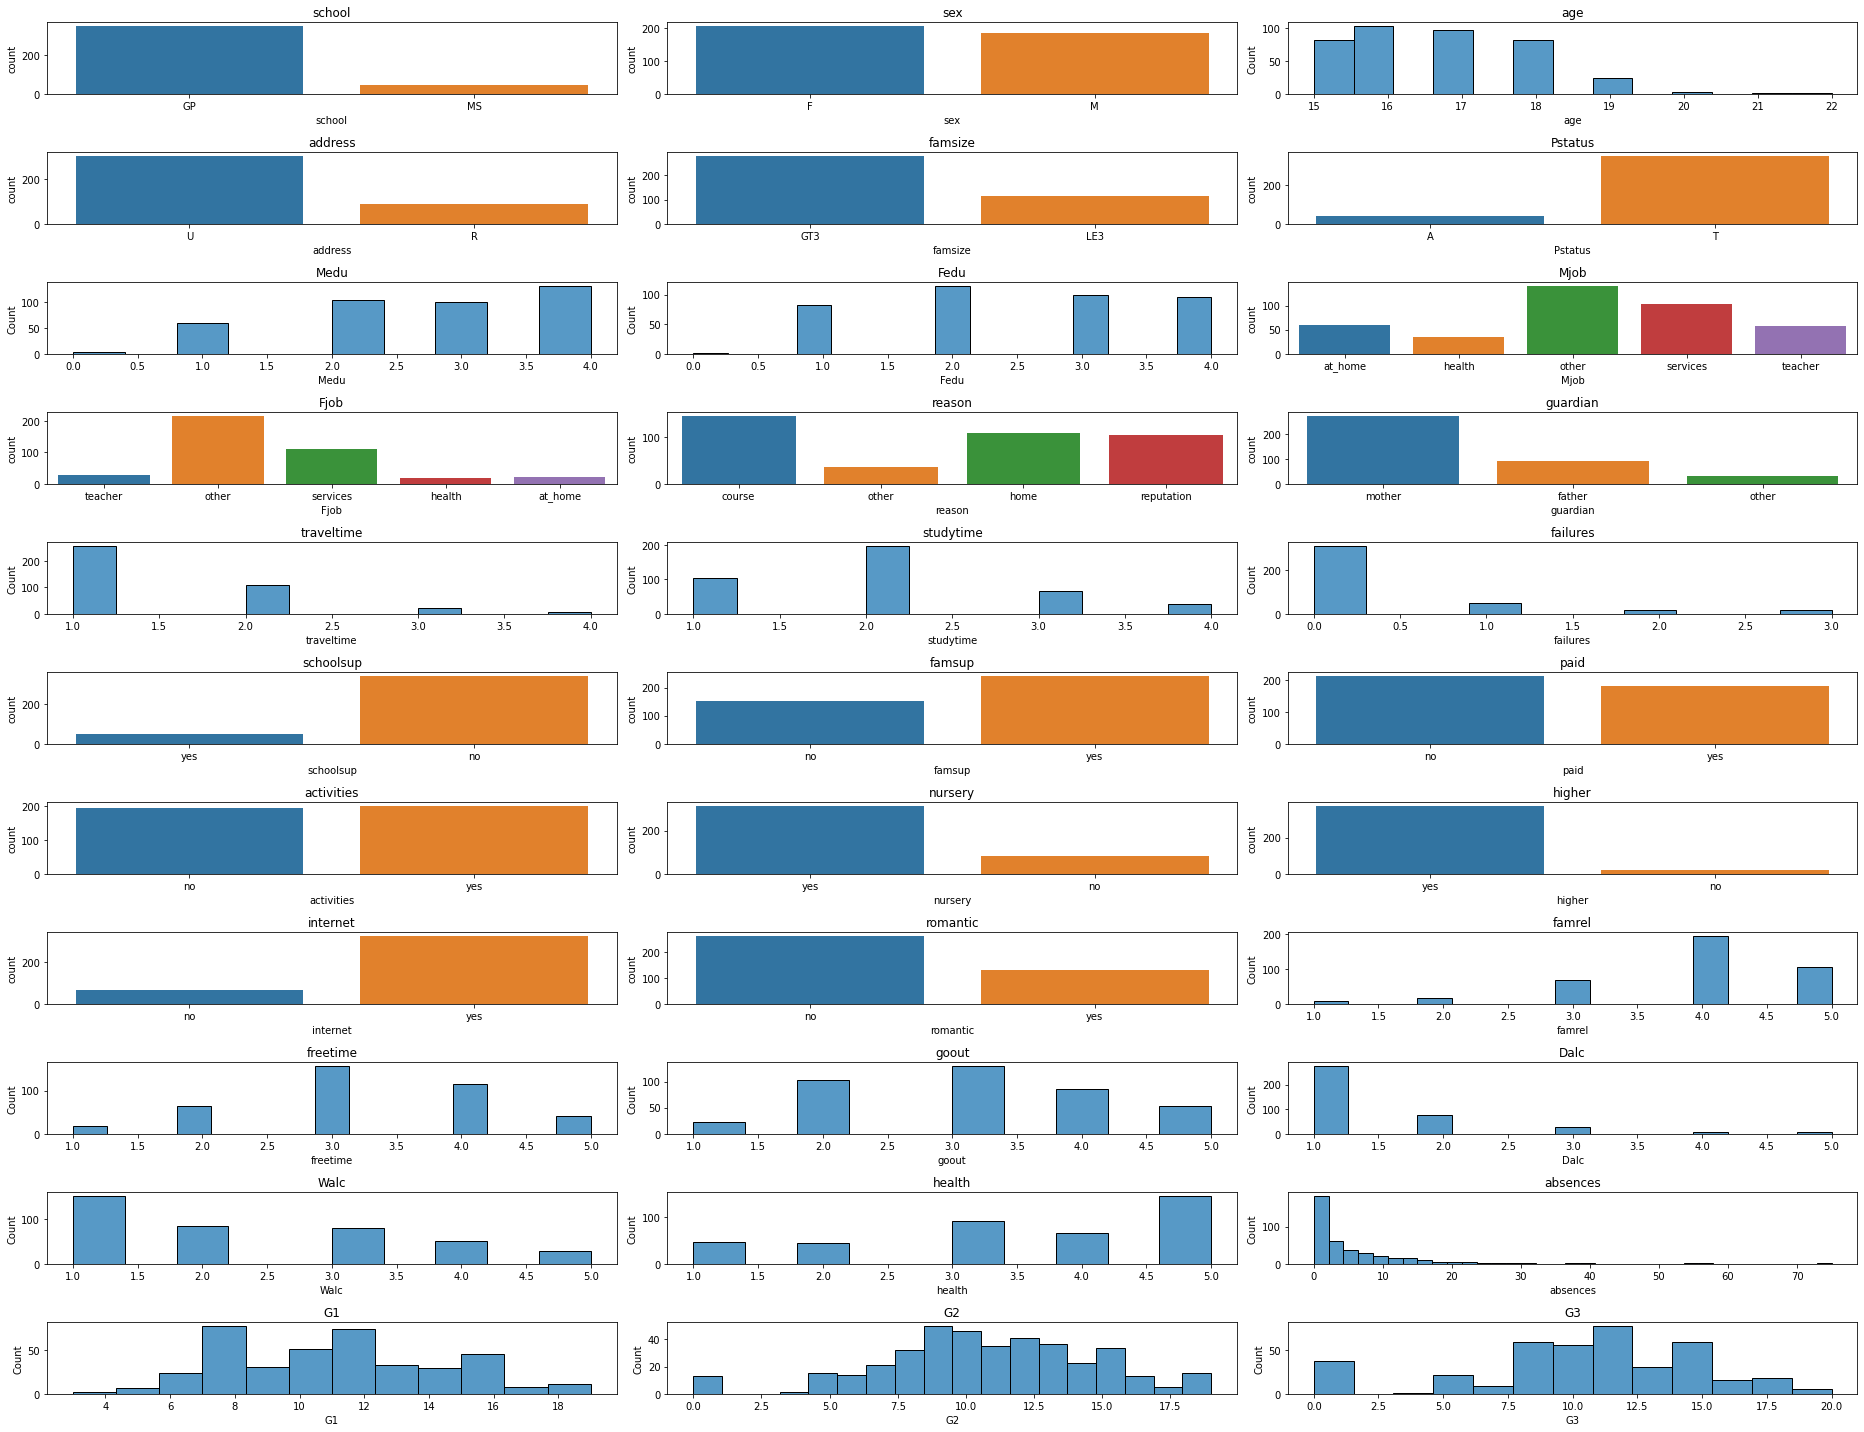

In [10]:
fig, axes = plt.subplots(11,3,figsize=(26,20))

for i, c in enumerate(mathdata):
    ax = axes.reshape(-1)[i]
    if mathdata[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=mathdata,ax=ax)
    else:
        b = sns.histplot(x=c,data=mathdata,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

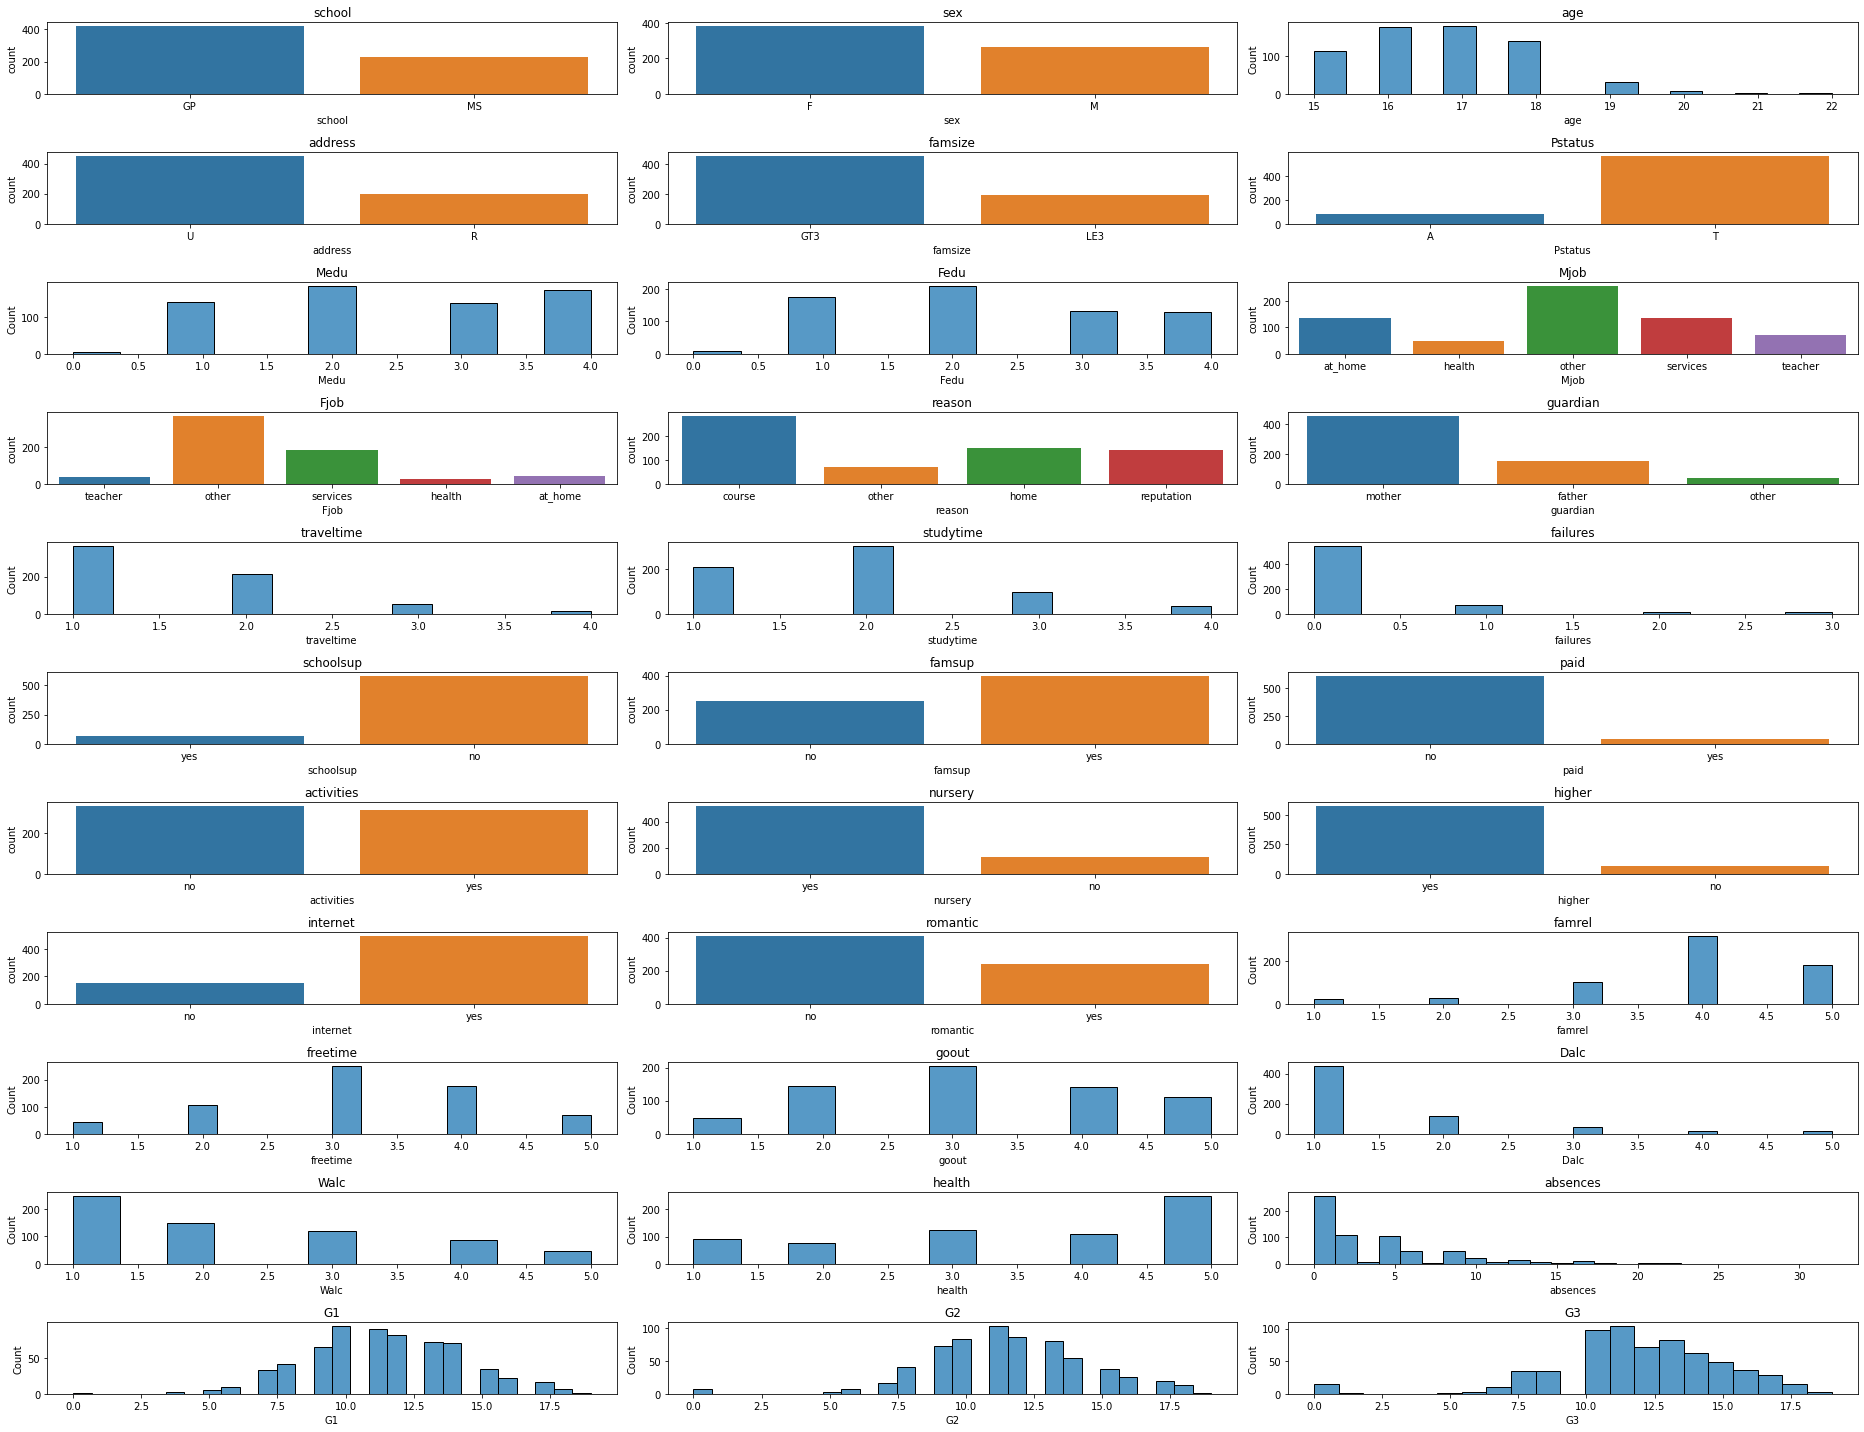

In [11]:
fig, axes = plt.subplots(11,3,figsize=(26,20))

for i, c in enumerate(portdata):
    ax = axes.reshape(-1)[i]
    if portdata[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=portdata,ax=ax)
    else:
        b = sns.histplot(x=c,data=portdata,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='school', ylabel='G3'>

<AxesSubplot:xlabel='school', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='sex', ylabel='G3'>

<AxesSubplot:xlabel='sex', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='address', ylabel='G3'>

<AxesSubplot:xlabel='address', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='famsize', ylabel='G3'>

<AxesSubplot:xlabel='famsize', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='Pstatus', ylabel='G3'>

<AxesSubplot:xlabel='Pstatus', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='Mjob', ylabel='G3'>

<AxesSubplot:xlabel='Mjob', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='Fjob', ylabel='G3'>

<AxesSubplot:xlabel='Fjob', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='reason', ylabel='G3'>

<AxesSubplot:xlabel='reason', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='guardian', ylabel='G3'>

<AxesSubplot:xlabel='guardian', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='schoolsup', ylabel='G3'>

<AxesSubplot:xlabel='schoolsup', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='famsup', ylabel='G3'>

<AxesSubplot:xlabel='famsup', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='paid', ylabel='G3'>

<AxesSubplot:xlabel='paid', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='activities', ylabel='G3'>

<AxesSubplot:xlabel='activities', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='nursery', ylabel='G3'>

<AxesSubplot:xlabel='nursery', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='higher', ylabel='G3'>

<AxesSubplot:xlabel='higher', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='internet', ylabel='G3'>

<AxesSubplot:xlabel='internet', ylabel='G3'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='romantic', ylabel='G3'>

<AxesSubplot:xlabel='romantic', ylabel='G3'>

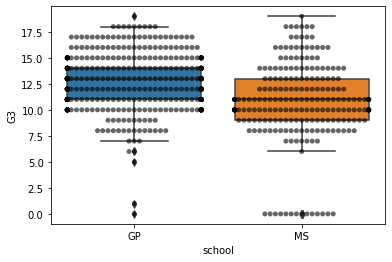

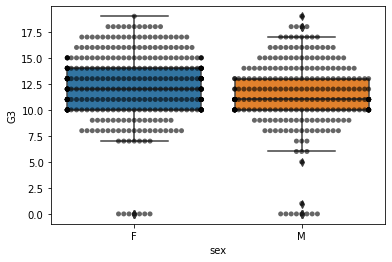

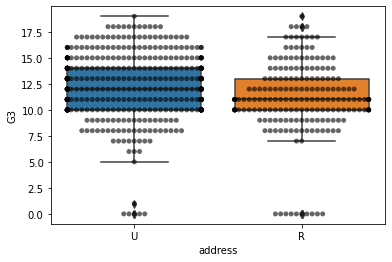

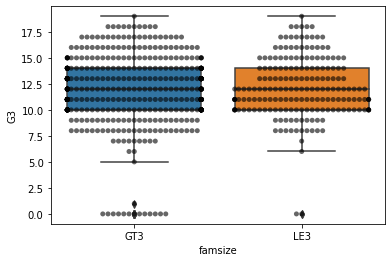

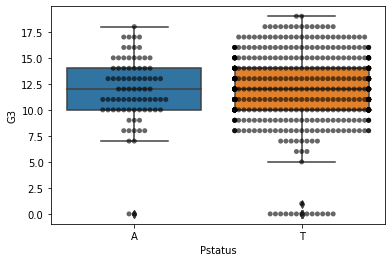

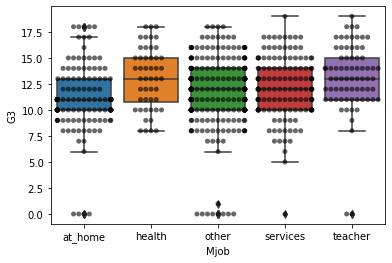

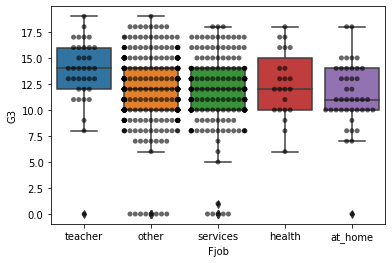

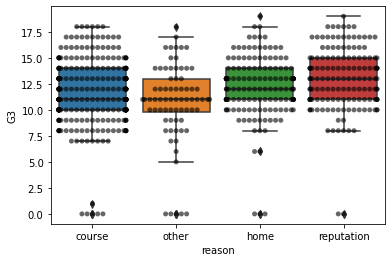

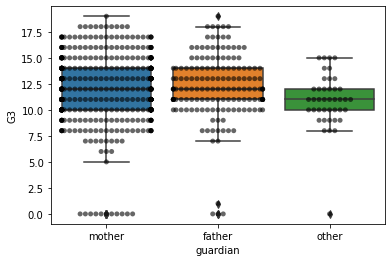

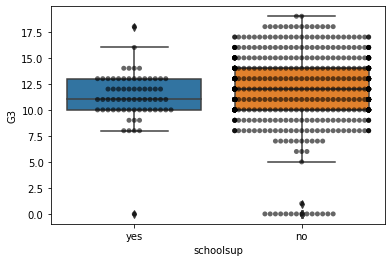

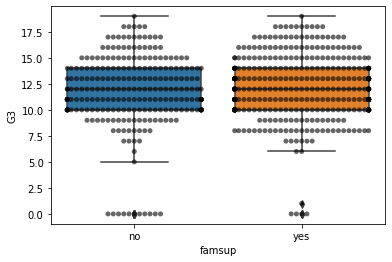

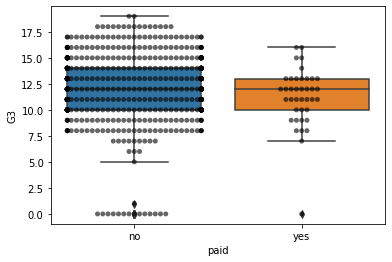

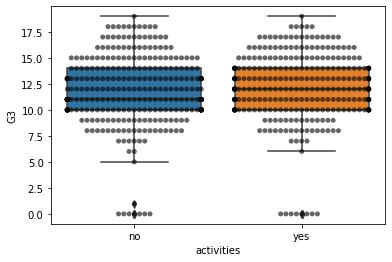

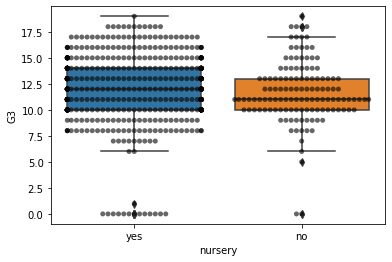

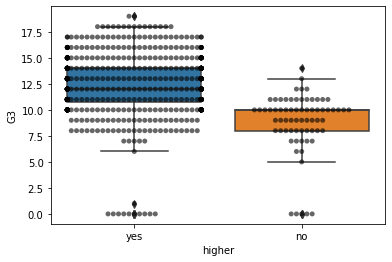

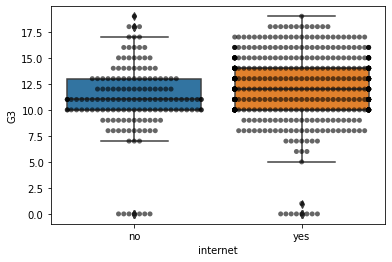

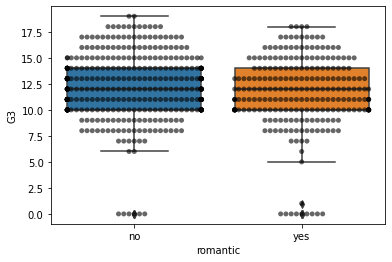

In [12]:
for i, col in enumerate(portdata.columns):
    if portdata[col].dtype.name == 'object':
        plt.figure(i)
        sns.boxplot(data = portdata, x=col, y='G3')
        sns.swarmplot(data = portdata, x=col, y='G3', color = 'k', alpha = 0.6)

## Outliers

<AxesSubplot:>

array([<AxesSubplot:title={'center':'age'}>], dtype=object)

15    112
16    177
17    179
18    140
19     32
20      6
21      2
22      1
Name: age, dtype: int64

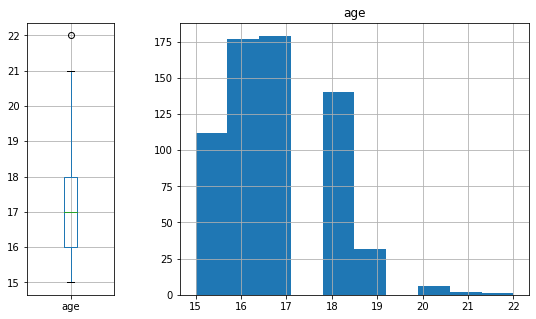

In [13]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
portdata.boxplot(column='age',ax=axes[0]);
portdata.hist(column='age', ax=axes[1]);

portdata["age"].value_counts().sort_index()

<AxesSubplot:>

array([<AxesSubplot:title={'center':'absences'}>], dtype=object)

0     244
1      12
2     110
3       7
4      93
5      12
6      49
7       3
8      42
9       7
10     21
11      5
12     12
13      1
14      8
15      2
16     10
18      3
21      2
22      2
24      1
26      1
30      1
32      1
Name: absences, dtype: int64

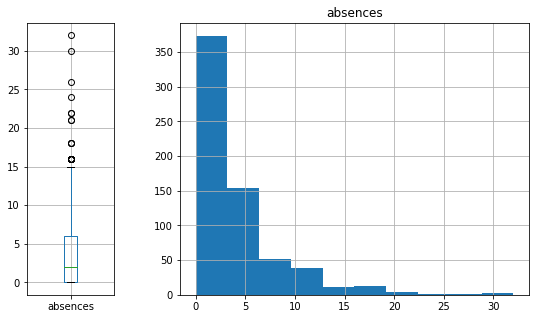

In [14]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
portdata.boxplot(column='absences',ax=axes[0]);
portdata.hist(column='absences', ax=axes[1]);

portdata["absences"].value_counts().sort_index()

We observe that absences follows an exponential distribution. And there are what appear to be extreme values that seem to fall from the distribution.

Text(0.5, 0, 'Absences')

Text(0, 0.5, 'G3')

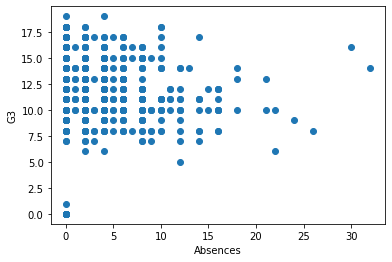

In [15]:
plt.scatter(portdata["absences"], portdata["G3"])
plt.xlabel("Absences")
plt.ylabel("G3")

We cannot observe a correlation between the G3 grade and the absences. And the outliers don't seem to affect to it.

This is why we decided to impute the mean value. Dropping them wasn't an option since we have few instances.

In [16]:
portdata[portdata["absences"]>=30]
mean_absences = np.mean(portdata["absences"])
mean_absences

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
197,GP,F,17,U,LE3,T,3,3,other,other,reputation,mother,1,2,0,no,yes,no,yes,yes,yes,yes,yes,5,3,3,2,3,1,32,14,13,14
212,GP,F,17,U,GT3,T,4,4,services,teacher,home,mother,2,1,1,no,yes,no,no,yes,yes,yes,no,4,2,4,2,3,2,30,14,15,16


3.6594761171032357

In [17]:
portdata.loc[portdata["absences"] > 30, "absences"] = mean_absences

<AxesSubplot:>

array([<AxesSubplot:title={'center':'absences'}>], dtype=object)

0.000000     244
1.000000      12
2.000000     110
3.000000       7
3.659476       1
4.000000      93
5.000000      12
6.000000      49
7.000000       3
8.000000      42
9.000000       7
10.000000     21
11.000000      5
12.000000     12
13.000000      1
14.000000      8
15.000000      2
16.000000     10
18.000000      3
21.000000      2
22.000000      2
24.000000      1
26.000000      1
30.000000      1
Name: absences, dtype: int64

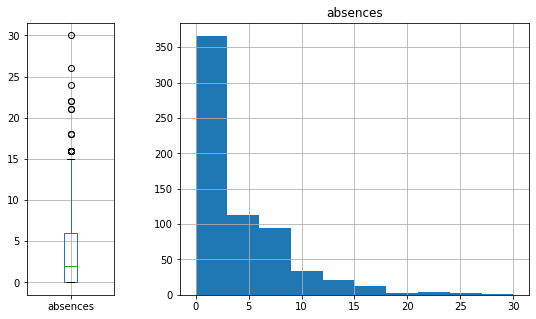

In [18]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
portdata.boxplot(column='absences',ax=axes[0]);
portdata.hist(column='absences', ax=axes[1]);

portdata["absences"].value_counts().sort_index()

<AxesSubplot:>

array([<AxesSubplot:title={'center':'G1'}>], dtype=object)

0      1
4      2
5      5
6      9
7     33
8     42
9     65
10    95
11    91
12    82
13    72
14    71
15    35
16    22
17    16
18     7
19     1
Name: G1, dtype: int64

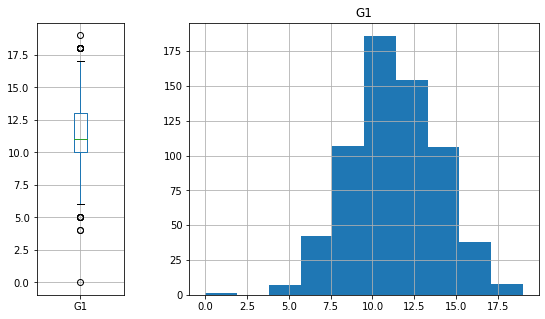

In [19]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
portdata.boxplot(column='G1',ax=axes[0]);
portdata.hist(column='G1', ax=axes[1]);

portdata["G1"].value_counts().sort_index()

<AxesSubplot:>

array([<AxesSubplot:title={'center':'G2'}>], dtype=object)

0       7
5       3
6       7
7      16
8      40
9      72
10     83
11    103
12     86
13     80
14     54
15     38
16     25
17     20
18     14
19      1
Name: G2, dtype: int64

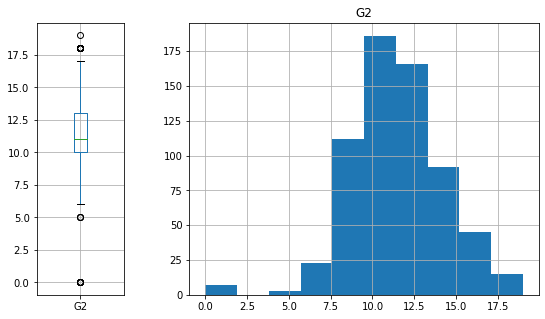

In [20]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
portdata.boxplot(column='G2',ax=axes[0]);
portdata.hist(column='G2', ax=axes[1]);

portdata["G2"].value_counts().sort_index()

<AxesSubplot:>

array([<AxesSubplot:title={'center':'G3'}>], dtype=object)

0      15
1       1
5       1
6       3
7      10
8      35
9      35
10     97
11    104
12     72
13     82
14     63
15     49
16     36
17     29
18     15
19      2
Name: G3, dtype: int64

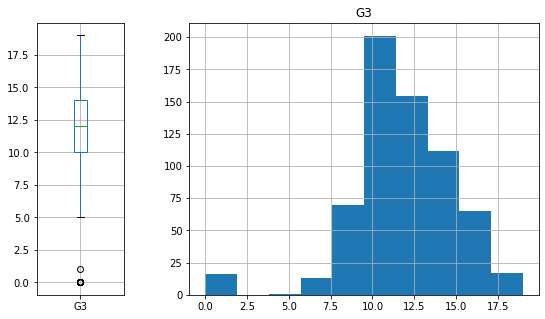

In [21]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
portdata.boxplot(column='G3',ax=axes[0]);
portdata.hist(column='G3', ax=axes[1]);

portdata["G3"].value_counts().sort_index()

Text(0.5, 0, 'G2')

Text(0, 0.5, 'G3')

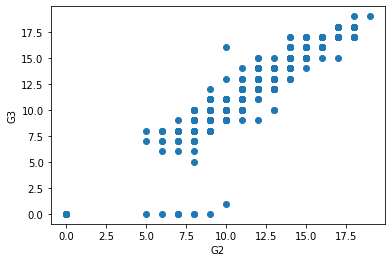

In [22]:
plt.scatter(portdata["G2"], portdata["G3"])
plt.xlabel("G2")
plt.ylabel("G3")

Text(0.5, 0, 'G1')

Text(0, 0.5, 'G3')

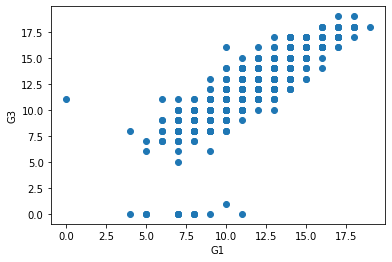

In [23]:
plt.scatter(portdata["G1"], portdata["G3"])
plt.xlabel("G1")
plt.ylabel("G3")

Text(0.5, 0, 'G1')

Text(0, 0.5, 'G2')

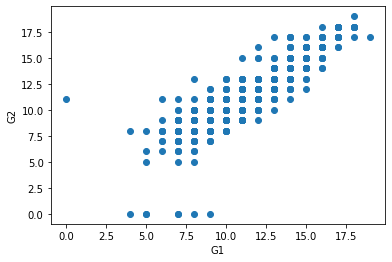

In [24]:
plt.scatter(portdata["G1"], portdata["G2"])
plt.xlabel("G1")
plt.ylabel("G2")

We can clearly observe that some students appear to be outliers. However, is in our interest to be able to classify this students, specially since they are students that failed the subject. Therefore, we will try to train our models with both configurations, with and without outliers.

Another option could be to consider the G3 equal to 0 to be NAs. And calculate them from the previous grades G1 and G2. However, since this was not mentioned in the original paper it is discarted.

In [25]:
portdata_clean = portdata.copy(deep=True)
index_names = portdata_clean[ (portdata_clean['G1'] < 2.5) | (portdata_clean['G2'] < 2.5) | (portdata_clean['G3'] < 2.5)].index
portdata_clean.drop(index_names, inplace = True)

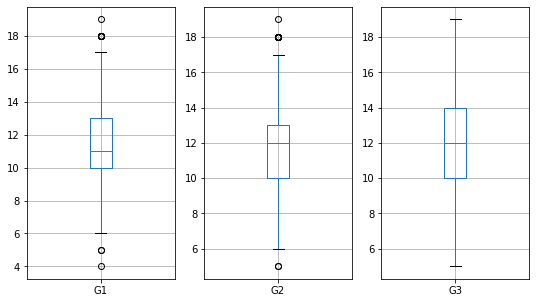

In [26]:
fig, axes= plt.subplots(1,3, gridspec_kw={'width_ratios': [1, 1, 1]}, figsize=(9,5))
portdata_clean.boxplot(column='G1',ax=axes[0]);
portdata_clean.boxplot(column='G2',ax=axes[1]);
portdata_clean.boxplot(column='G3',ax=axes[2]);

### Transformation from categorical to numerical

We will to treat all our categorical variables as numerical. To do so, we used one hot encoding. 

In [27]:
mathdata['subject'] = 'Mathematics'
portdata['subject'] = 'Portuguese'

students = mathdata.append(portdata, ignore_index=True)

cols = ['Medu', 'Fedu', 'traveltime', 'studytime', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
students[cols] = students[cols].astype(str)
portdata_clean[cols] = portdata_clean[cols].astype(str)

students_encoded = pd.get_dummies(students, drop_first=True)
portdata_clean_encoded = pd.get_dummies(portdata_clean, drop_first=True)


## Response variable

We transformed our response variable from numerical to binary.

Following the preocupation of the original paper. Because, we want to differentiate between students that pass and students that fail. To be able to detect the failing cases before happening.

In [28]:
students_encoded['pass_fail'] = np.where(students_encoded['G3'] >= 10, 1,0)

In [29]:
portdata_clean_encoded['pass_fail'] = np.where(portdata_clean_encoded['G3'] >= 10, 1,0)
port_clean = portdata_clean_encoded
port_clean["pass_fail"].value_counts()

1    548
0     84
Name: pass_fail, dtype: int64

In [30]:
port = students_encoded[students_encoded['subject_Portuguese'] == 1].drop(columns='subject_Portuguese')
math = students_encoded[students_encoded['subject_Portuguese'] == 0].drop(columns='subject_Portuguese')

In [31]:
port["pass_fail"].value_counts()
math["pass_fail"].value_counts()

1    549
0    100
Name: pass_fail, dtype: int64

1    265
0    130
Name: pass_fail, dtype: int64

## Feature importance

One advantage that RF and DT have is that they perform feature selection on training.
We will use RF to have a more profound understanding of which features are the most important for the RF model.

In [32]:
rf_train_portdata = port.drop(columns=['G3', 'pass_fail'])
rf = RandomForestClassifier(oob_score=True, random_state=1234).fit(rf_train_portdata, port["pass_fail"])

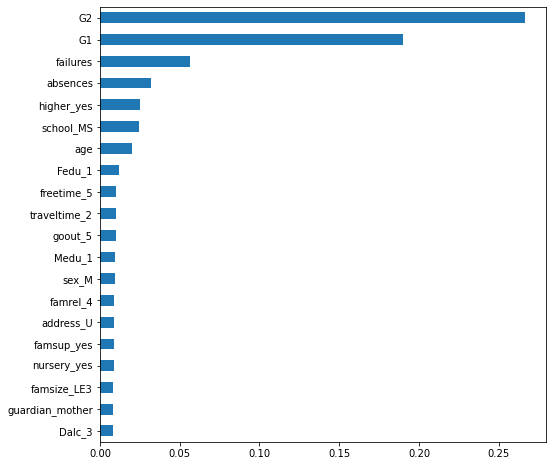

In [33]:
var_imp = pd.DataFrame({'importance': rf.feature_importances_}, index=rf_train_portdata.columns)

var_imp.sort_values(by='importance').tail(20).plot.barh(figsize=(8,8), legend=False);

According to our RF model, `G2` and `G1` are the most important variables for predicting the `pass_fail` target. Followed by: `failures`, `absences`, `higher`, `school` and `age`.

In [34]:
print('OOB accuracy=', rf.oob_score_)

OOB accuracy= 0.9229583975346687


By checking that the OOB is not low, we can have greater confidence with the variable selection of the RF.

## Feature selection

In the start of the EDA, we observed that some variables didn't show any sign of distinction between its values and the final grade and also from the previous section the RF model returned only a subset of the variables as their most important. However, we will keep all of them while we see that they don't affect negatively the results of the models. Also, since we have a low number of examples and we want to generalize also for the math data set, we need to have as much information as possible.

## Data set partition

For the train/validation/test data sets, we will choose **stratified partitions**; what this means is that we will keep the same proportion of pass/fail examples in each partition. Since we have an imbalanced dataset this is important considering that a random partition may increase the imbalance.

In [35]:
X = port.drop(columns=['G3', 'pass_fail'])
y = port.pass_fail

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=123, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train, random_state=124, shuffle=True)

In [36]:
X_train.shape, X_test.shape, X_val.shape
y_train.value_counts(), y_test.value_counts(), y_val.value_counts()

((415, 69), (130, 69), (104, 69))

(1    351
 0     64
 Name: pass_fail, dtype: int64,
 1    110
 0     20
 Name: pass_fail, dtype: int64,
 1    88
 0    16
 Name: pass_fail, dtype: int64)

In [37]:
X_clean = port_clean.drop(columns=['G3', 'pass_fail'])
y_clean = port_clean.pass_fail

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.20, stratify=y_clean, random_state=123, shuffle=True)

In [38]:
X_train_clean.shape, X_test_clean.shape
y_train_clean.value_counts(), y_test_clean.value_counts()

((505, 69), (127, 69))

(1    438
 0     67
 Name: pass_fail, dtype: int64,
 1    110
 0     17
 Name: pass_fail, dtype: int64)

## Normalizing

We will normalize the numerical variables in order that the scale of a variable doesn't affect the hole model. This will make all the variables have the same importance when training the models that are not scale resistant.

In [39]:
num_cols = ['G2', 'G1', 'age', 'absences', 'failures']
ct = ColumnTransformer([("std", StandardScaler(), num_cols)], remainder='passthrough')

X_train = ct.fit_transform(X_train)
X_val = ct.fit_transform(X_val)
X_test = ct.fit_transform(X_test)

## Choosing metrics

Now we have to decide which are going to be our cross validation metrics. 


**Accuracy:**

$$accuracy = \frac{\sum_c tp_c}{n}$$

Where tp_c are the true positive predictions for all the classes and n are the total number of samples. This metric is **sensitive to imbalanced data**.

**Precision (of a class):**

$$precision_c = \frac{tp}{tp + fp}$$

Where $tp$ are the true positives (samples correctly predicted of this class) and fp are the false positives (samples from another class predicted incorrectly as this class). This metric measures how much the model is predicting correctly a class with respect all the predictions of this class. We will use this metric when having false positive predictions is very harmful in our model context. 


**Recall (of a class):**

$$recall_c = =\frac{tp}{tp + fn}$$

Where $tp$ are the true positives (samples correctly predicted of this class) and fn are the false negatives (samples from this class predicted incorrectly as a different class). This metric measures how much the model is predicting correctly a class with respect all the real values of this class. We will use this metric when having false negative predictions is very harmful in our model context.

**F1-score (of a class):**

$$\frac{2 * precission_c * recall_c }{precission_c + recall_c}$$

The **harmonic mean** of precision and recall. We will use this metric when we want a good balance between precision and recall.  

We are going to use the: F1-score of the classes, F1 macro, and accuracy metrics. 

These metrics will give us a precise view of how our model is performing. In this particular problem the fail class is more important, as we have an imbalanced data set and the easy classification for the model would be to assign everything to the pass class. However, we consider that classifying a good student as a fail and a bad student as a pass have the same impact. For this reason we will use the macro average of the F1-score instead of focusing on the metrics of one specific class. The macro average means averaging the class-metrics. But we will still keep the F1-score of the classes and accuracy to be able to have at the same time a good idea of how the classification of each class is going on and a general view of the model, even though it would not be representative for us.

# LDA

In [40]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda_train = lda_model.predict(X_train)
y_pred_lda = lda_model.predict(X_val)

LinearDiscriminantAnalysis()

In [41]:
confusion(pd.Series(y_val), pd.Series(y_pred_lda))

predicted,0,1
target,,
0,9,7
1,5,83


In [42]:
print(classification_report(y_val, y_pred_lda))

              precision    recall  f1-score   support

           0       0.64      0.56      0.60        16
           1       0.92      0.94      0.93        88

    accuracy                           0.88       104
   macro avg       0.78      0.75      0.77       104
weighted avg       0.88      0.88      0.88       104



In [43]:
results_port.loc['LDA', :] = compute_metrics(y_val, y_pred_lda)
results_port

,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
LDA,0.932584,0.6,0.766292,0.884615


Text(0.5, 1.0, 'Dimensionality reduction of the training instances')

Text(0.5, 0, 'LDA dimension')

Text(0, 0.5, '')

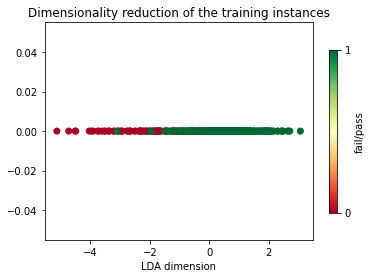

In [44]:
data_plot = lda_model.transform(X_train)

plt.scatter(data_plot.flatten(), np.zeros(y_train.size), c=y_train, cmap="RdYlGn")
plt.colorbar(label="fail/pass", orientation="vertical",shrink=.75, ticks=np.linspace(0, 1, 2))
plt.title("Dimensionality reduction of the training instances")
plt.xlabel("LDA dimension")
plt.ylabel("")

Text(0.5, 1.0, 'Dimensionality reduction of the training instances')

Text(0.5, 0, 'LDA dimension')

Text(0, 0.5, 'Individual number')

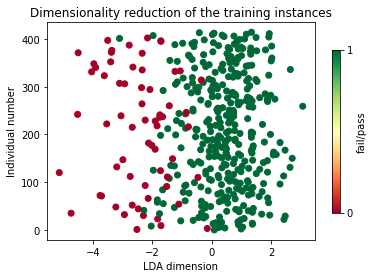

In [45]:
data_plot = lda_model.transform(X_train)

plt.scatter(data_plot.flatten(), np.arange(y_train.size), c=y_train, cmap="RdYlGn")
plt.colorbar(label="fail/pass", orientation="vertical",shrink=.75, ticks=np.linspace(0, 1, 2))
plt.title("Dimensionality reduction of the training instances")
plt.xlabel("LDA dimension")
plt.ylabel("Individual number")

Text(0.5, 1.0, 'Dimensionality reduction of the training instances')

Text(0.5, 0, 'LDA dimension')

Text(0, 0.5, 'Real pass/fail')

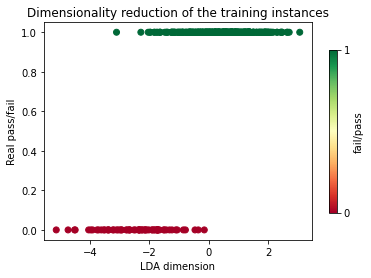

In [46]:
data_plot = lda_model.transform(X_train)

plt.scatter(data_plot.flatten(), y_train, c=y_train, cmap="RdYlGn")
plt.colorbar(label="fail/pass", orientation="vertical",shrink=.75, ticks=np.linspace(0, 1, 2))
plt.title("Dimensionality reduction of the training instances")
plt.xlabel("LDA dimension")
plt.ylabel("Real pass/fail")

Text(0.5, 1.0, 'Dimensionality reduction of the training instances')

Text(0.5, 0, 'LDA dimension')

Text(0, 0.5, 'Predicted pass/fail')

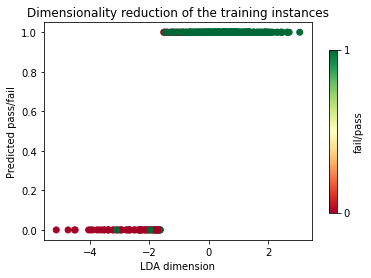

In [47]:
data_plot = lda_model.transform(X_train)

plt.scatter(data_plot.flatten(), y_pred_lda_train, c=y_train, cmap="RdYlGn")
plt.colorbar(label="fail/pass", orientation="vertical",shrink=.75, ticks=np.linspace(0, 1, 2))
plt.title("Dimensionality reduction of the training instances")
plt.xlabel("LDA dimension")
plt.ylabel("Predicted pass/fail")

Text(0.5, 1.0, 'Dimensionality reduction of the validation instances')

Text(0.5, 0, 'LDA dimension')

Text(0, 0.5, 'Predicted pass/fail')

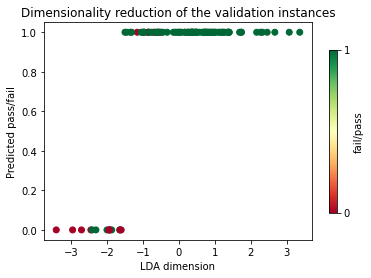

In [48]:
data_plot = lda_model.transform(X_val)

plt.scatter(data_plot.flatten(), y_pred_lda, c=y_val, cmap="RdYlGn")
plt.colorbar(label="fail/pass", orientation="vertical",shrink=.75, ticks=np.linspace(0, 1, 2))
plt.title("Dimensionality reduction of the validation instances")
plt.xlabel("LDA dimension")
plt.ylabel("Predicted pass/fail")

# QDA

In [49]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'reg'));
results_qda = pd.DataFrame(index=index, columns= ['**F1-score (class pass)**', '**F1-score (class fail)**','F1-score (macro avg)', 'Accuracy']);

regularization_parameters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10];

for reg in regularization_parameters:
    qda_model = QuadraticDiscriminantAnalysis(reg_param=reg);
    qda_model = qda_model.fit(X_train,y_train);
    y_pred = qda_model.predict(X_val);
    results_qda.loc[('QDA',reg), :] = compute_metrics(y_val, y_pred);

results_qda.sort_values(by='F1-score (macro avg)', ascending=False)

**F1-score (class pass)** **F1-score (class fail)**  \
model reg                                                           
QDA   1.0000                   0.931034                  0.647059   
      0.5000                   0.913043                  0.333333   
      0.1000                   0.920635                  0.210526   
      0.0000                   0.916667                       0.0   
      0.0001                   0.916667                       0.0   
      0.0010                   0.916667                       0.0   
      0.0100                   0.916667                       0.0   
      5.0000                        0.0                  0.266667   
      10.0000                       0.0                  0.266667   

              F1-score (macro avg)  Accuracy  
model reg                                     
QDA   1.0000              0.789047  0.884615  
      0.5000              0.623188  0.846154  
      0.1000              0.565581  0.855769  
      0.0000              0.458333  0.846154  
      0.0001              0.458333  0.846154  
      0.0010              0.458333  0.846154  
      0.0100              0.458333  0.846154  
      5.0000              0.133333  0.153846  
      10.0000             0.133333  0.153846

In [50]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=1);
qda_model = qda_model.fit(X_train,y_train);
y_pred_qda = qda_model.predict(X_val);

results_port.loc['QDA-1', :] = compute_metrics(y_val, y_pred_qda)
results_port

,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
LDA,0.932584,0.6,0.766292,0.884615
QDA-1,0.931034,0.647059,0.789047,0.884615


In [51]:
confusion(y_val, pd.Series(y_pred_qda))

predicted,0,1
target,,
0,11,5
1,7,81


# Naive Bayes

In [52]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train,y_train)
y_pred_gnb = gaussian_nb.predict(X_val);

results_port.loc['Gaussian-NB', :] = compute_metrics(y_val, y_pred_gnb);
results_port

,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
LDA,0.932584,0.6,0.766292,0.884615
QDA-1,0.931034,0.647059,0.789047,0.884615
Gaussian-NB,0.886228,0.536585,0.711406,0.817308


In [53]:
X = port.drop(columns=['G3', 'pass_fail'])
y = port.pass_fail

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=123, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train, random_state=124, shuffle=True)

num_cols = ['G2', 'G1', 'age', 'absences', 'failures']
cat_cols = np.setdiff1d(X.columns.values.tolist(), num_cols).tolist()
ct_num = ColumnTransformer([("std", StandardScaler(), num_cols)])

X_train_num = ct_num.fit_transform(pd.DataFrame(X_train))
X_val_num = ct_num.fit_transform(pd.DataFrame(X_val))
X_test_num = ct_num.fit_transform(pd.DataFrame(X_test))

X_train_cat = X_train[cat_cols]
X_val_cat = X_val[cat_cols]
X_test_cat = X_test[cat_cols]

In [54]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train_num,y_train)
y_pred_gnb_num = gaussian_nb.predict(X_val_num);

results_port.loc['Gaussian-NB-only-numerical', :] = compute_metrics(y_val, y_pred_gnb_num);


cat_nb = CategoricalNB()
cat_nb = cat_nb.fit(X_train_cat,y_train)
y_pred_gnb_cat = cat_nb.predict(X_val_cat);

results_port.loc['Gaussian-NB-only-categorical', :] = compute_metrics(y_val, y_pred_gnb_cat);

results_port

,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
LDA,0.932584,0.6,0.766292,0.884615
QDA-1,0.931034,0.647059,0.789047,0.884615
Gaussian-NB,0.886228,0.536585,0.711406,0.817308
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
Gaussian-NB-only-categorical,0.886364,0.375,0.630682,0.807692


In [55]:
combined_prediction_proba = cat_nb.predict_proba(X_val_cat) * gaussian_nb.predict_proba(X_val_num)

combined_prediction = np.argmax(combined_prediction_proba,axis=1)

results_port.loc['Combined-NB', :] = compute_metrics(y_val, combined_prediction);
results_port

,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
LDA,0.932584,0.6,0.766292,0.884615
QDA-1,0.931034,0.647059,0.789047,0.884615
Gaussian-NB,0.886228,0.536585,0.711406,0.817308
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
Gaussian-NB-only-categorical,0.886364,0.375,0.630682,0.807692
Combined-NB,0.920455,0.5625,0.741477,0.865385


In [56]:
results_port.sort_values(by='F1-score (macro avg)',ascending=False)

,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
QDA-1,0.931034,0.647059,0.789047,0.884615
LDA,0.932584,0.6,0.766292,0.884615
Combined-NB,0.920455,0.5625,0.741477,0.865385
Gaussian-NB,0.886228,0.536585,0.711406,0.817308
Gaussian-NB-only-categorical,0.886364,0.375,0.630682,0.807692


Now there is a last probability trick that we can use. As we want to be completely sure that our model is predicting 1 only when the student is passing the subject, instead of selecting the class with the maximum probability value, we can select class 1 only when the combined probability of class 1 is greater than 0.55.  

In [57]:
def only_one_when_you_are_sure(x):
    if x[1] > 0.55:
        return 1
    else:
        return 0

combined_pred_tuned = pd.DataFrame(combined_prediction_proba).apply(only_one_when_you_are_sure, axis=1)

results_port.loc['Combined-NB-tuned', :] = compute_metrics(y_val, combined_pred_tuned);

results_port.sort_values(by='F1-score (macro avg)',ascending=False)

,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
QDA-1,0.931034,0.647059,0.789047,0.884615
LDA,0.932584,0.6,0.766292,0.884615
Combined-NB,0.920455,0.5625,0.741477,0.865385
Combined-NB-tuned,0.873418,0.6,0.736709,0.807692
Gaussian-NB,0.886228,0.536585,0.711406,0.817308
Gaussian-NB-only-categorical,0.886364,0.375,0.630682,0.807692


In [58]:
confusion(y_val, combined_pred_tuned)

predicted,0,1
target,,
0,15,1
1,19,69


# Logistic Regression

In [59]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'));
results_logreg = pd.DataFrame(index=index, columns= ['**F1-score (class pass)**', '**F1-score (class fail)**','F1-score (macro avg)', 'Accuracy']);

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C);
    logreg = logreg.fit(X_train,y_train);
    y_pred = logreg.predict(X_val);
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred);

results_logreg.sort_values(by='F1-score (macro avg)', ascending=False)

**F1-score (class pass)** **F1-score (class fail)**  \
model  C                                                              
LogReg 0.1                       0.955056                  0.733333   
       10.0                      0.943182                    0.6875   
       1.0                        0.94382                  0.666667   
       1000.0                    0.924855                  0.628571   
       100.0                     0.925714                  0.606061   
       10000.0                   0.926554                  0.580645   
       100000.0                  0.920455                    0.5625   

                F1-score (macro avg)  Accuracy  
model  C                                        
LogReg 0.1                  0.844195  0.923077  
       10.0                 0.815341  0.903846  
       1.0                  0.805243  0.903846  
       1000.0               0.776713     0.875  
       100.0                0.765887     0.875  
       10000.0              0.753599     0.875  
       100000.0             0.741477  0.865385

In [60]:
logreg = LogisticRegression(C=0.1).fit(X_train,y_train);
y_pred_logreg = logreg.predict(X_val);
results_port.loc['LogReg-0.1', :] = compute_metrics(y_val, y_pred_logreg);

results_port.sort_values(by='F1-score (macro avg)', ascending=False)

,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
QDA-1,0.931034,0.647059,0.789047,0.884615
LDA,0.932584,0.6,0.766292,0.884615
Combined-NB,0.920455,0.5625,0.741477,0.865385
Combined-NB-tuned,0.873418,0.6,0.736709,0.807692
Gaussian-NB,0.886228,0.536585,0.711406,0.817308
Gaussian-NB-only-categorical,0.886364,0.375,0.630682,0.807692


In [61]:
confusion(y_val, pd.Series(y_pred_logreg))

predicted,0,1
target,,
0,11,5
1,3,85


# Decision Trees

Transform categorical variables into numbers because we are working with decision trees

A Decision Tree predicts the target by learning simple decision rules. During the training it will split the data so it can learn these rules. This model will be very fast to train and interpretable but we have to be aware that it can overfit easily. 

Hyperparameters: 
* `criterion`: gini or entropy 
* `max_depth`: maximum depth of the tree. Controls complexity. 
* `min_samples_split`: minimum number of samples required to split an internal node. Controls complexity. 
* `min_samples_leaf`: minimum number of samples required to be at a leaf node. Controls complexity.

## Default tree

In [62]:
model_tree = DecisionTreeClassifier(random_state=1234).fit(X_train, 
                                          y_train)

In [63]:
y_pred = model_tree.predict(X_val)

results_port.loc['DT-default',:] = compute_metrics(y_val, y_pred)

confusion(y_val, y_pred)

predicted,0,1
target,,
0,11,5
1,6,82


In [64]:
print(classification_report(y_val,
                            y_pred,
                            target_names=['fail', 'pass'],))

results_port.sort_values(by='F1-score (macro avg)', ascending=False)

              precision    recall  f1-score   support

        fail       0.65      0.69      0.67        16
        pass       0.94      0.93      0.94        88

    accuracy                           0.89       104
   macro avg       0.79      0.81      0.80       104
weighted avg       0.90      0.89      0.90       104



,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
DT-default,0.937143,0.666667,0.801905,0.894231
QDA-1,0.931034,0.647059,0.789047,0.884615
LDA,0.932584,0.6,0.766292,0.884615
Combined-NB,0.920455,0.5625,0.741477,0.865385
Combined-NB-tuned,0.873418,0.6,0.736709,0.807692
Gaussian-NB,0.886228,0.536585,0.711406,0.817308
Gaussian-NB-only-categorical,0.886364,0.375,0.630682,0.807692


With the default configuration we obtained a high accuracy, however the F1-score of class 0 is very low compared to it. We should try to improve the F1-score for the fail class while trying to keep the accuracy.

We can try to improve these results by optimizing its hyperparameters. We are going to use gridsearchcv from sklearn to do it.

In [65]:
criterion = ['gini', 'entropy']

max_dephts = [None, 4, 5, 10, 15, 20, 30]
min_samples_split = [3, 4, 5, 6, 8]
min_samples_leaf = [ 3, 4, 5, 6, 8]
max_features = ['auto', 'sqrt', 'log2', None]

init_time = time()
model_tree = DecisionTreeClassifier(random_state=1234)

f1_class_fail_scorer = make_scorer(f1_score, pos_label=0)
f1_class_pass_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_fail': f1_class_fail_scorer,
    'f1_class_pass': f1_class_pass_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=5,
                   return_train_score=False,
                   refit='f1_mac')

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:38.516950


In [66]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_fail', 'mean_test_f1_class_pass', 'mean_test_acc'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',
                                                 ascending=False)[scoring_cols].head()

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_fail,mean_test_f1_class_pass,mean_test_acc
199,gini,4,None,8,8,0.872459,0.783268,0.96165,0.93494
198,gini,4,None,8,6,0.872459,0.783268,0.96165,0.93494
197,gini,4,None,8,5,0.872459,0.783268,0.96165,0.93494
196,gini,4,None,8,4,0.872459,0.783268,0.96165,0.93494
195,gini,4,None,8,3,0.872459,0.783268,0.96165,0.93494


In [67]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 8,
 'min_samples_split': 8}

In [68]:
best_model_tree = DecisionTreeClassifier(**best_params).fit(X_train, y_train)
y_pred = best_model_tree.predict(X_val)

results_port.loc['DT-best',:] = compute_metrics(y_val, y_pred)

confusion(y_val,y_pred)
results_port.sort_values(by='F1-score (macro avg)', ascending=False)

predicted,0,1
target,,
0,10,6
1,4,84


,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
DT-best,0.94382,0.666667,0.805243,0.903846
DT-default,0.937143,0.666667,0.801905,0.894231
QDA-1,0.931034,0.647059,0.789047,0.884615
LDA,0.932584,0.6,0.766292,0.884615
Combined-NB,0.920455,0.5625,0.741477,0.865385
Combined-NB-tuned,0.873418,0.6,0.736709,0.807692
Gaussian-NB,0.886228,0.536585,0.711406,0.817308
Gaussian-NB-only-categorical,0.886364,0.375,0.630682,0.807692


With the best DT we weren't able to improve the F1-score for the fail class but improved the F1-score macro average. However, there are still some missclassifications, lets see if with other models we can do a better classification.

In [69]:
def tree_to_code(tree, feature_names):
    """ Code from paulkernfeld 
        Source: https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree 
    """
    
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, np.argmax(tree_.value[node][0])))

    recurse(0, 1)

In [70]:
tree_to_code(best_model_tree, X_train.columns)

  if G2 <= 8.5:
    if G1 <= 8.5:
      if freetime_3 <= 0.5:
        return 0
      else:  # if freetime_3 > 0.5
        return 0
    else:  # if G1 > 8.5
      return 0
  else:  # if G2 > 8.5
    if G1 <= 8.5:
      if absences <= 5.0:
        return 1
      else:  # if absences > 5.0
        return 0
    else:  # if G1 > 8.5
      if G2 <= 10.5:
        if health_5 <= 0.5:
          return 1
        else:  # if health_5 > 0.5
          return 1
      else:  # if G2 > 10.5
        if Medu_1 <= 0.5:
          return 1
        else:  # if Medu_1 > 0.5
          return 1


# Random Forests

Random Forest is an ensemble of Decision Trees; the idea is that by averaging high-variance but decorrelated individual decision trees we will avoid their tendency to overfitting. 

They introduce the **Out-of-Bag** (OOB) error. This error is a metric that we can compute on Random Forest model while training. It is very very useful because it allows us to perform model selection (tune hyperparameters) without having to execute costly cross-validations.

While training, RF separates the data into subsets with replacement and trains the different trees of the forest with them. The OOB score is obtained by computing the accuracy of the trees on a set of samples that were not being used to train each specific tree. So, it acts as a **validation** score rather than a training one.

In [71]:
model_rf1 = RandomForestClassifier(oob_score=True, random_state=1234).fit(X_train, y_train)

pred = model_rf1.predict(X_train)

print(classification_report(y_train,
                            pred,
                            target_names=['fail', 'pass'],))

print('OOB accuracy=', model_rf1.oob_score_)

              precision    recall  f1-score   support

        fail       1.00      1.00      1.00        64
        pass       1.00      1.00      1.00       351

    accuracy                           1.00       415
   macro avg       1.00      1.00      1.00       415
weighted avg       1.00      1.00      1.00       415

OOB accuracy= 0.9228915662650602


The RF gives us an OOB accuracy of 92% which is an estimation of the test accuaracy.  

However, let's compute the real test error:

In [72]:
y_pred = model_rf1.predict(X_val)
print('Validation Accuracy:{}'.format(model_rf1.score(X_val,y_val)))
results_port.loc['RF-default',:] = compute_metrics(y_val,y_pred)
confusion(y_val,y_pred)

Validation Accuracy:0.9134615384615384


predicted,0,1
target,,
0,9,7
1,2,86


In [73]:
results_port.sort_values(by='F1-score (macro avg)', ascending=False)

,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
RF-default,0.950276,0.666667,0.808471,0.913462
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
DT-best,0.94382,0.666667,0.805243,0.903846
DT-default,0.937143,0.666667,0.801905,0.894231
QDA-1,0.931034,0.647059,0.789047,0.884615
LDA,0.932584,0.6,0.766292,0.884615
Combined-NB,0.920455,0.5625,0.741477,0.865385
Combined-NB-tuned,0.873418,0.6,0.736709,0.807692
Gaussian-NB,0.886228,0.536585,0.711406,0.817308


The RF has not been able to improve the resutls obtained with the LogReg. Since it has a worse F1-score for class fail.
Meaning that there is an issue with the imbalance in our target class.

To deal with it, we will make use of **class weights**.

There are two options: *balanced* and *balanced_subsample*.

The *balanced* mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as $$\frac{n\_samples}{n\_classes * np.bincount(y)}$$

The *balanced_subsample* mode is the same as *balanced* except that weights are computed based on the bootstrap sample for every tree grown.

In [74]:
model_rf2 = RandomForestClassifier(oob_score=True, class_weight='balanced', random_state=1234).fit(X_train, y_train)

pred = model_rf2.predict(X_train)

print(classification_report(y_train,pred,target_names=['fail', 'pass'],))

print('OOB accuracy=', model_rf2.oob_score_)

              precision    recall  f1-score   support

        fail       1.00      1.00      1.00        64
        pass       1.00      1.00      1.00       351

    accuracy                           1.00       415
   macro avg       1.00      1.00      1.00       415
weighted avg       1.00      1.00      1.00       415

OOB accuracy= 0.8987951807228916


With a better balance; let's compute the real test error:

In [75]:
y_pred = model_rf2.predict(X_val)

results_port.loc['RF-balance',:] = compute_metrics(y_val,y_pred)

confusion(y_val,y_pred)

predicted,0,1
target,,
0,10,6
1,1,87


In [76]:
model_rf3 = RandomForestClassifier(oob_score=True, class_weight='balanced_subsample', random_state=1234).fit(X_train, y_train)

pred = model_rf3.predict(X_train)

print(classification_report(y_train,pred,target_names=['fail', 'pass'],))

print('OOB accuracy=', model_rf3.oob_score_)

y_pred = model_rf3.predict(X_val)

results_port.loc['RF-balance-sub',:] = compute_metrics(y_val,y_pred)

confusion(y_val,y_pred)

              precision    recall  f1-score   support

        fail       1.00      1.00      1.00        64
        pass       1.00      1.00      1.00       351

    accuracy                           1.00       415
   macro avg       1.00      1.00      1.00       415
weighted avg       1.00      1.00      1.00       415

OOB accuracy= 0.9036144578313253


predicted,0,1
target,,
0,10,6
1,2,86


In [77]:
results_port.sort_values(by='F1-score (macro avg)', ascending=False)

,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
RF-balance,0.961326,0.740741,0.851033,0.932692
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
RF-balance-sub,0.955556,0.714286,0.834921,0.923077
RF-default,0.950276,0.666667,0.808471,0.913462
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
DT-best,0.94382,0.666667,0.805243,0.903846
DT-default,0.937143,0.666667,0.801905,0.894231
QDA-1,0.931034,0.647059,0.789047,0.884615
LDA,0.932584,0.6,0.766292,0.884615
Combined-NB,0.920455,0.5625,0.741477,0.865385


Using class weights has helped to improve the F1-score of class fail and the F-1 score overall.

We will try to tune our model hyperparameters to see if it can obtain a better classification of the class fail.

In [78]:
init_time = time()

rf_model = RandomForestClassifier(random_state=1234)

ntrees = [50, 100, 500, None]
max_depth = [20, 50, None]
min_samples_split = [2, 3, 6]
min_samples_leaf = [2, 3, 6]
balance = [None, 'balanced', 'balanced_subsample']

rfgscv = GridSearchCV(estimator=rf_model,
                       scoring=scoring_dict,
                       param_grid={
                           'n_estimators': ntrees,
                           'max_depth':max_depth,
                           'min_samples_split':min_samples_split,
                           'min_samples_leaf':min_samples_leaf, 
                           'class_weight':balance
                       },
                       cv=5,
                       return_train_score=False,
                       refit=False,
                       n_jobs=-1)

model_5CV = rfgscv.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:37.551094


In [79]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
    'mean_test_f1_mac', 'mean_test_f1_class_fail', 'mean_test_f1_class_pass',
    'mean_test_acc'
]
pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_fail,mean_test_f1_class_pass,mean_test_acc
230,20,3,2,0.866009,0.775177,0.956841,0.927711
310,None,3,6,0.866009,0.775177,0.956841,0.927711
306,None,3,3,0.866009,0.775177,0.956841,0.927711
302,None,3,2,0.866009,0.775177,0.956841,0.927711
274,50,3,6,0.866009,0.775177,0.956841,0.927711


In [80]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced_subsample',
 'max_depth': 20,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

Let's refit the best new model

In [81]:
rf_model_tuned = RandomForestClassifier(**best_params, random_state=1234)
rf_model_tuned.fit(X_train, y_train)

y_pred = rf_model_tuned.predict(X_val)

results_port.loc['RF-best', :] = compute_metrics(y_val, y_pred)

results_port.sort_values(by='F1-score (macro avg)', ascending=False)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_leaf=3, n_estimators=500, random_state=1234)

,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
RF-best,0.954023,0.764706,0.859364,0.923077
RF-balance,0.961326,0.740741,0.851033,0.932692
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
RF-balance-sub,0.955556,0.714286,0.834921,0.923077
RF-default,0.950276,0.666667,0.808471,0.913462
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
DT-best,0.94382,0.666667,0.805243,0.903846
DT-default,0.937143,0.666667,0.801905,0.894231
QDA-1,0.931034,0.647059,0.789047,0.884615
LDA,0.932584,0.6,0.766292,0.884615


With the RF we have parametrized, we have been able to improve the F1-score of the class fail respect to the default RF.

# SVM

First, we will train our SVM model without tuning the hyper-parameters.

In [82]:
svm_model = SVC(random_state=54321)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_val)
  
results_port.loc['SVM-default',:] = compute_metrics(y_val, y_pred)

confusion(y_val, y_pred)

SVC(random_state=54321)

predicted,0,1
target,,
0,7,9
1,0,88


In [83]:
print(classification_report(y_val,
                            y_pred,
                            target_names=['fail', 'pass'],))
results_port.sort_values(by='F1-score (macro avg)', ascending=False)

              precision    recall  f1-score   support

        fail       1.00      0.44      0.61        16
        pass       0.91      1.00      0.95        88

    accuracy                           0.91       104
   macro avg       0.95      0.72      0.78       104
weighted avg       0.92      0.91      0.90       104



,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
RF-best,0.954023,0.764706,0.859364,0.923077
RF-balance,0.961326,0.740741,0.851033,0.932692
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
RF-balance-sub,0.955556,0.714286,0.834921,0.923077
RF-default,0.950276,0.666667,0.808471,0.913462
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
DT-best,0.94382,0.666667,0.805243,0.903846
DT-default,0.937143,0.666667,0.801905,0.894231
QDA-1,0.931034,0.647059,0.789047,0.884615
SVM-default,0.951351,0.608696,0.780024,0.913462


We obtained a high accuracy, but this does not mean nothing since the important metric is the F1-score for class fail where the score is very lower compared to the one of the class pass.
We will use Grid Search to tune the hyperparameters and try to improve the F1-score metric for class fail.

In [84]:
c_values = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]
kernel = ['rbf', 'sigmoid']

svm_model = SVC(random_state=54321) 

f1_class_fail_scorer = make_scorer(f1_score, pos_label=0)
f1_class_pass_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_fail': f1_class_fail_scorer,
    'f1_class_pass': f1_class_pass_scorer,
    'acc': 'accuracy'
}

init_time = time()
  
grid = GridSearchCV(svm_model, 
                    scoring=scoring_dict,
                    param_grid = {'C': c_values, 
                                  'gamma': gamma,
                                  'kernel': kernel}, 
                    cv=5,
                    return_train_score=False,
                    refit = 'f1_mac')

model_5CV = grid.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:02.040577


In [85]:
scoring_cols = [
    'param_C', 'param_gamma', 'param_kernel', 'mean_test_f1_mac',
    'mean_test_f1_class_fail', 'mean_test_f1_class_pass', 'mean_test_acc'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',
                                                 ascending=False)[scoring_cols].head()

,param_C,param_gamma,param_kernel,mean_test_f1_mac,mean_test_f1_class_fail,mean_test_f1_class_pass,mean_test_acc
49,1000,0.0001,sigmoid,0.858729,0.756640,0.960817,0.932530
38,100,0.0001,rbf,0.858699,0.756583,0.960816,0.932530
26,10,0.001,rbf,0.854423,0.749468,0.959379,0.930120
44,1000,0.01,rbf,0.852908,0.749777,0.956040,0.925301
34,100,0.01,rbf,0.852908,0.749777,0.956040,0.925301


The best parameters we found are

In [86]:
best_params = model_5CV.best_params_
best_params

{'C': 1000, 'gamma': 0.0001, 'kernel': 'sigmoid'}

In [87]:
best_svm_model = SVC(**best_params, random_state=54321).fit(X_train, y_train)
y_pred = best_svm_model.predict(X_val)

results_port.loc['SVM-best',:] = compute_metrics(y_val, y_pred)

confusion(y_val,y_pred)

predicted,0,1
target,,
0,11,5
1,3,85


In [88]:
results_port = results_port.sort_values(by='F1-score (macro avg)', ascending=False)
results_port.sort_values(by='F1-score (macro avg)', ascending=False)

,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
RF-best,0.954023,0.764706,0.859364,0.923077
RF-balance,0.961326,0.740741,0.851033,0.932692
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
SVM-best,0.955056,0.733333,0.844195,0.923077
RF-balance-sub,0.955556,0.714286,0.834921,0.923077
RF-default,0.950276,0.666667,0.808471,0.913462
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
DT-best,0.94382,0.666667,0.805243,0.903846
DT-default,0.937143,0.666667,0.801905,0.894231
QDA-1,0.931034,0.647059,0.789047,0.884615


We were able to improve the F1-score of class fail and the accuracy.

Since we know that SVM is one of the models that can be affected negatively with bad variables. We will train it with the variables that we obtained from the feature selection of the RF. Which were `G2`, `G1`, `failures`, `absences`, `higher`, `school` and `age`.

In [89]:
X_train.columns

Index(['age', 'failures', 'absences', 'G1', 'G2', 'school_MS', 'sex_M',
       'address_U', 'famsize_LE3', 'Pstatus_T', 'Medu_1', 'Medu_2', 'Medu_3',
       'Medu_4', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4', 'Mjob_health',
       'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_health',
       'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_home',
       'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'traveltime_2', 'traveltime_3', 'traveltime_4',
       'studytime_2', 'studytime_3', 'studytime_4', 'schoolsup_yes',
       'famsup_yes', 'paid_yes', 'activities_yes', 'nursery_yes', 'higher_yes',
       'internet_yes', 'romantic_yes', 'famrel_2', 'famrel_3', 'famrel_4',
       'famrel_5', 'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5',
       'goout_2', 'goout_3', 'goout_4', 'goout_5', 'Dalc_2', 'Dalc_3',
       'Dalc_4', 'Dalc_5', 'Walc_2', 'Walc_3', 'Walc_4', 'Walc_5', 'health_2',
       'health_3', 'health_4', 'health_5'],
      dtype

In [90]:
feature_selection = ['G2', 'G1', 'failures', 'absences', 'higher_yes', 'school_MS', 'age']
X_train_imp = X_train[feature_selection]
X_val_imp = X_val[feature_selection]

svm_model_fs = SVC(**best_params, random_state=54321).fit(X_train_imp, y_train)

y_pred = svm_model_fs.predict(X_val_imp)
  
results_port.loc['SVM-FS',:] = compute_metrics(y_val, y_pred)

confusion(y_val, y_pred)

results_port.sort_values(by='F1-score (macro avg)', ascending=False)

predicted,0,1
target,,
0,13,3
1,4,84


,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
SVM-FS,0.96,0.787879,0.873939,0.932692
RF-best,0.954023,0.764706,0.859364,0.923077
RF-balance,0.961326,0.740741,0.851033,0.932692
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
SVM-best,0.955056,0.733333,0.844195,0.923077
RF-balance-sub,0.955556,0.714286,0.834921,0.923077
RF-default,0.950276,0.666667,0.808471,0.913462
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
DT-best,0.94382,0.666667,0.805243,0.903846
DT-default,0.937143,0.666667,0.801905,0.894231


# Multi Layered Perceptron (Neural Networks)

Regularized and activated by logistic.

Simple model

In [91]:
model_nnet = MLPClassifier(hidden_layer_sizes=[1],
                           alpha=0,
                           activation='logistic',
                           max_iter=200,
                           solver='lbfgs',random_state=42)
model_nnet.fit(X_train, y_train);


y_pred = model_nnet.predict(X_train)

print('Confusion matrix of the TRAIN dataset')
confusion(y_train, y_pred)

f1_class_fail_scorer = make_scorer(f1_score, pos_label=0)
f1_class_pass_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_fail': f1_class_fail_scorer,
    'f1_class_pass': f1_class_pass_scorer,
    'acc': 'accuracy'
}

y_pred = model_nnet.predict(X_val)
confusion(y_val, y_pred)

results_port.loc['MLP[1]',:] = compute_metrics(y_val, y_pred)

results_port.sort_values(by='F1-score (macro avg)', ascending=False)

MLPClassifier(activation='logistic', alpha=0, hidden_layer_sizes=[1],
              random_state=42, solver='lbfgs')

Confusion matrix of the TRAIN dataset


predicted,0,1
target,,
0,0,64
1,0,351


predicted,0,1
target,,
0,0,16
1,0,88


,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
SVM-FS,0.96,0.787879,0.873939,0.932692
RF-best,0.954023,0.764706,0.859364,0.923077
RF-balance,0.961326,0.740741,0.851033,0.932692
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
SVM-best,0.955056,0.733333,0.844195,0.923077
RF-balance-sub,0.955556,0.714286,0.834921,0.923077
RF-default,0.950276,0.666667,0.808471,0.913462
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
DT-best,0.94382,0.666667,0.805243,0.903846
DT-default,0.937143,0.666667,0.801905,0.894231


It happen the worst case we could expect, that is, classifying all the students to the pass class. This is why we chosed the F1-score metric since for this case the accuracy is high but it is not at all what we want the model to do.

## Hyperparameter tuning

Testing different parameters

In [92]:
sizes = [2*i for i in range(1,5)]
sizes = sizes + [[2*i,2*i] for i in range(1,5)]
sizes = sizes + [[2*i,2*i, 2*i] for i in range(1,5)]

len(sizes), sizes


decays = [0.00001,0.0001,0.001,0.01,0.1,0.5,1]
len(decays), decays[:10] 

(12,
 [2,
  4,
  6,
  8,
  [2, 2],
  [4, 4],
  [6, 6],
  [8, 8],
  [2, 2, 2],
  [4, 4, 4],
  [6, 6, 6],
  [8, 8, 8]])

(7, [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 1])

In [93]:
init_time=time()
model_nnet = MLPClassifier(alpha=0,
                           activation='logistic',
                           max_iter=500,
                           solver='lbfgs',
                           random_state=42)

trc = GridSearchCV(estimator=model_nnet,
                   scoring=['f1_macro', 'precision_macro', 'recall_macro', 'accuracy'],
                   param_grid={'hidden_layer_sizes': sizes,
                              'alpha': decays},
                   cv=10,
                   return_train_score=True,
                   refit='f1_macro')

model_10CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time()-init_time)))

0:02:05.959538


In [94]:
pd.DataFrame(model_10CV.cv_results_).loc[:,['param_alpha','param_hidden_layer_sizes',  'mean_test_f1_macro', 
                                            'std_test_f1_macro','mean_test_precision_macro', 'std_test_precision_macro',
                                        'mean_test_accuracy','std_test_accuracy',]].sort_values(by='mean_test_f1_macro',
                                                                                                ascending=False).head()

,param_alpha,param_hidden_layer_sizes,mean_test_f1_macro,std_test_f1_macro,mean_test_precision_macro,std_test_precision_macro,mean_test_accuracy,std_test_accuracy
76,1,"[2, 2]",0.859976,0.059472,0.872213,0.084187,0.925145,0.035402
75,1,8,0.852139,0.067385,0.871284,0.086061,0.922822,0.037368
78,1,"[6, 6]",0.851407,0.071599,0.870731,0.087670,0.922764,0.038992
72,1,2,0.851407,0.071599,0.870731,0.087670,0.922764,0.038992
77,1,"[4, 4]",0.849798,0.068613,0.860058,0.079683,0.920441,0.037683


In [95]:
model_10CV.best_params_
model_10CV.best_score_

{'alpha': 1, 'hidden_layer_sizes': [2, 2]}

0.8599757697987336

Best parameter would be $\alpha = 1$ and architecture [2,2]

In [96]:
f1_class_fail_scorer = make_scorer(f1_score, pos_label=0)
f1_class_pass_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_fail': f1_class_fail_scorer,
    'f1_class_pass': f1_class_pass_scorer,
    'acc': 'accuracy'
}

mlp_predict_port = model_10CV.best_estimator_.predict(X_val)
confusion(y_val, mlp_predict_port)

results_port.loc['MLP[2,2]-alpha=1',:] = compute_metrics(y_val, mlp_predict_port)

results_port.sort_values(by='F1-score (macro avg)', ascending=False)

predicted,0,1
target,,
0,12,4
1,8,80


,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
SVM-FS,0.96,0.787879,0.873939,0.932692
RF-best,0.954023,0.764706,0.859364,0.923077
RF-balance,0.961326,0.740741,0.851033,0.932692
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
SVM-best,0.955056,0.733333,0.844195,0.923077
RF-balance-sub,0.955556,0.714286,0.834921,0.923077
RF-default,0.950276,0.666667,0.808471,0.913462
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
DT-best,0.94382,0.666667,0.805243,0.903846
DT-default,0.937143,0.666667,0.801905,0.894231


In [97]:
y_pred = model_10CV.predict(X_val)

confusion(y_val,y_pred)

print(classification_report(y_val, y_pred))

predicted,0,1
target,,
0,12,4
1,8,80


              precision    recall  f1-score   support

           0       0.60      0.75      0.67        16
           1       0.95      0.91      0.93        88

    accuracy                           0.88       104
   macro avg       0.78      0.83      0.80       104
weighted avg       0.90      0.88      0.89       104



Since we know that NN are also affected by irrelevant data, we will do the same we did for the SVM.

In [98]:
mlp_model_fs = MLPClassifier(**model_10CV.best_params_, random_state=42).fit(X_train_imp, y_train)

y_pred = mlp_model_fs.predict(X_val_imp)
confusion(y_val, y_pred)

results_port.loc['MLP[2,2]-alpha=1-FS',:] = compute_metrics(y_val, y_pred)

results_port.sort_values(by='F1-score (macro avg)', ascending=False)

predicted,0,1
target,,
0,0,16
1,0,88


,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
SVM-FS,0.96,0.787879,0.873939,0.932692
RF-best,0.954023,0.764706,0.859364,0.923077
RF-balance,0.961326,0.740741,0.851033,0.932692
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
SVM-best,0.955056,0.733333,0.844195,0.923077
RF-balance-sub,0.955556,0.714286,0.834921,0.923077
RF-default,0.950276,0.666667,0.808471,0.913462
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
DT-best,0.94382,0.666667,0.805243,0.903846
DT-default,0.937143,0.666667,0.801905,0.894231


The results have worsen drastically.

# Results

In [99]:
results_port.sort_values(by='F1-score (macro avg)', ascending=False)

,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
SVM-FS,0.96,0.787879,0.873939,0.932692
RF-best,0.954023,0.764706,0.859364,0.923077
RF-balance,0.961326,0.740741,0.851033,0.932692
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
SVM-best,0.955056,0.733333,0.844195,0.923077
RF-balance-sub,0.955556,0.714286,0.834921,0.923077
RF-default,0.950276,0.666667,0.808471,0.913462
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
DT-best,0.94382,0.666667,0.805243,0.903846
DT-default,0.937143,0.666667,0.801905,0.894231


# Generalization Performance

To ensure that this generalization performance is the closest posible to the performance we would obtain on new data, we are going to use our test partition to evaluate it.

In [100]:
X_test_imp = X_test[feature_selection]

y_pred = svm_model_fs.predict(X_test_imp)

results_port_best = pd.DataFrame(index=[], columns= ['**F1-score (class pass)**', '**F1-score (class fail)**','F1-score (macro avg)', 'Accuracy'])
results_port_best.loc['SVM-FS',:] = compute_metrics(y_test, y_pred)

confusion(y_test, y_pred)
results_port_best

predicted,0,1
target,,
0,17,3
1,3,107


,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
SVM-FS,0.972727,0.85,0.911364,0.953846


# Predicting Maths from Portuguese training

In [101]:
X_math = math.drop(columns=['G3', 'pass_fail'])
y_math = math.pass_fail

X_math_imp = X_math[feature_selection]

In [102]:
y_pred_math = svm_model_fs.predict(X_math_imp)
confusion(y_math, y_pred_math)
print(classification_report(y_math, y_pred_math))

results_math = pd.DataFrame(index=[], columns= ['**F1-score (class pass)**', '**F1-score (class fail)**','F1-score (macro avg)', 'Accuracy'])
results_math.loc['SVM-FS',:] = compute_metrics(y_math, y_pred_math)
results_math

predicted,0,1
target,,
0,101,29
1,12,253


              precision    recall  f1-score   support

           0       0.89      0.78      0.83       130
           1       0.90      0.95      0.93       265

    accuracy                           0.90       395
   macro avg       0.90      0.87      0.88       395
weighted avg       0.90      0.90      0.89       395



,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
SVM-FS,0.925046,0.831276,0.878161,0.896203


# Most important variables

<AxesSubplot:>

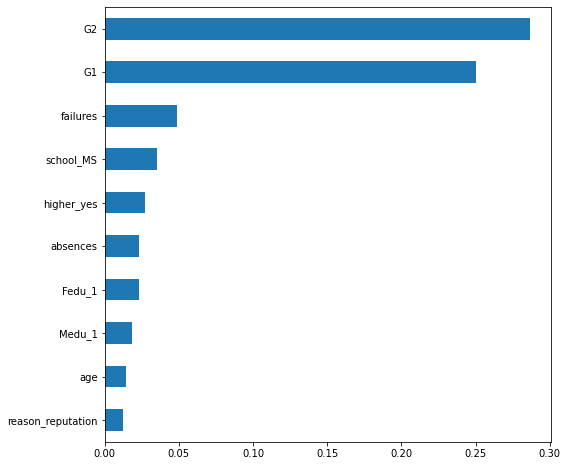

In [103]:
var_imp = pd.DataFrame({'importance': rf_model_tuned.feature_importances_}, index=X_train.columns)

var_imp.sort_values(by='importance').tail(10).plot.barh(figsize=(8,8), legend=False)

# Without outliers

As mentioned before, we wanted also to check if the prediction will improve if we remove the students that are suspicious of being outliers. Therefore, we will train the best model with the data of the portuguese subject without outliers and test it with the test partition. No validation will be needed since this was the best model we obtained previously and we assume that since the data set won't change drastically the best model won't change.

In [104]:
feature_selection = ['G2', 'G1', 'failures', 'absences', 'higher_yes', 'school_MS', 'age']
X_train_clean_imp = X_train_clean[feature_selection]
X_test_clean_imp = X_test_clean[feature_selection]

svm_model_clean = SVC(**best_params, random_state=54321).fit(X_train_clean_imp, y_train_clean)
y_pred = svm_model_clean.predict(X_test_clean_imp)

results_port.loc['SVM-with-clean',:] = compute_metrics(y_test_clean, y_pred)

confusion(y_test_clean, y_pred)
results_port.sort_values(by='F1-score (macro avg)', ascending=False)

predicted,0,1
target,,
0,11,6
1,3,107


,**F1-score (class pass)**,**F1-score (class fail)**,F1-score (macro avg),Accuracy
SVM-FS,0.96,0.787879,0.873939,0.932692
RF-best,0.954023,0.764706,0.859364,0.923077
RF-balance,0.961326,0.740741,0.851033,0.932692
LogReg-0.1,0.955056,0.733333,0.844195,0.923077
SVM-best,0.955056,0.733333,0.844195,0.923077
RF-balance-sub,0.955556,0.714286,0.834921,0.923077
SVM-with-clean,0.959641,0.709677,0.834659,0.929134
RF-default,0.950276,0.666667,0.808471,0.913462
Gaussian-NB-only-numerical,0.929412,0.684211,0.806811,0.884615
DT-best,0.94382,0.666667,0.805243,0.903846


We observed that with the data without the students we considered outliers the prediction does not seem to improve. Showing that the cases harder to correctly classify aren't the supposed outliers.